In [53]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.datasets import make_classification
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../')

In [3]:
from mc_hammer.cluster_measures import cvnn_sep, scatter, radial_density,dataset_midpoint_dist, dataset_meancenter_dist
from mc_hammer.cluster_measures import mean_center_dist,max_center_dist,max_diam, mean_max_diam,mean_all
from mc_hammer.similarity_functions import IGP, sillhouette_euclidean
from mc_hammer.circular_cluster_generator import generate_data
from mc_hammer.clustering_algorithms import k_means

## Functions

In [4]:
def gouss_dist(dim,seed_n):
    seed(seed_n)
    std = uniform(0.1,0.3)
    null_arr = np.array([np.random.normal(1,std,100) for i in range(dim)])
    return null_arr.T

In [5]:
def get_centers(x,labs):
    centers_list = []
    for k in range(max(labs)+1):
        one_clust = x[labs==k,:]
        center = one_clust.mean(axis = 0)
        centers_list.append(center)
    cent_array = np.array(centers_list)
    return cent_array

In [6]:
def gauss_clust_generator(k,dimx,sep,n,se,noise):
    noise_dim = int(round(dimx*noise))
    inf_dim = dimx - noise_dim
    x,labs = make_classification(
        n_samples = n,
        n_features = dimx,
        n_informative = inf_dim,
        n_redundant = noise_dim,
        n_classes = k,
        n_clusters_per_class = 1,
        class_sep = sep,
        random_state = se
    ) 
    x = x/x.max()
    centers = get_centers(x,labs)
    return x,labs,centers

In [7]:
def get_metrics_results(res_dicts,method,addit = None):
    res_list = [] 
    for i in range(len(res_dicts['x'])):
        x = res_dicts['x'][i]
        labs = res_dicts['labs'][i]
        centers = res_dicts['centers'][i]
        if method in ['mean_all','mean_max_diam','max_diam','mean_center_dist','max_center_dist']:
            res = eval(method + '(x,labs,centers)')
        elif method in ['scatter','cvnn_sep','IGP', 'sillhouette_euclidean']:
            res = eval(method + '(x,labs)')
        elif method in ['dataset_midpoint_dist', 'dataset_meancenter_dist']:
            res = eval(method + '(x,centers)')
        else:
            res = eval(method + '(x,centers,labs,addit)')
        res_list.append(res)
    return(res_list)

In [8]:
def get_k(test_string):
    test_2 = re.sub('.*k_','',test_string,)
    k = int(re.sub('_.*','',test_2))
    return k

In [9]:
def list_sorter(metric_list,method):
    if method == 'max':
        new_list = [max(i) for i in metric_list]
    elif method == 'min':
        new_list = [min(i) for i in metric_list]
    else:
        new_list = [np.mean(i) for i in metric_list]
    return new_list

In [178]:
def name_delete(x):
    x = re.sub('_dim_.*_k_[0-9]{1,2}','',x)
    x = re.sub('km_','',x)
    x = re.sub('unequal_','',x)
    x = re.sub('equal_','',x)
    x = re.sub('__','_',x)
    return(x)

In [38]:
def get_grouped(metric_dict,keys_dict):
    new_dict = {k:[] for k in keys_dict.keys()}
    for k,v in keys_dict.items():
        for i in v:
            new_dict[k].append(metric_dict[i])
    new_dict = {k:[j for i in v for j in i] for k,v in new_dict.items()}
    return new_dict

In [113]:
def get_colours(clust_var):
    if ('gauss_dis' in clust_var) or ('uni_dis' in clust_var):
        return 'gray'
    elif 'circ_clust' in clust_var:
        return 'darkviolet'
    else:
        return 'lightseagreen'

In [133]:
def make_df(dist_dict,metric):
    df_dict = {k:pd.DataFrame({
        'clust type':[k for i in range(len(v))],
        'values':v,
        'metric':[metric for i in range(len(v))]}) for k,v in dist_dict.items()}
    test_pd = pd.concat(df_dict.values())
    return test_pd

## Parameters

In [11]:
clusters = [2,3,4]
dim = [5,10,20]
sep = [0.5,1,3]
noise = [0,0.2,0.5]

## Uniform Distribution

In [12]:
uni_dis = {'uni_dis_dim_' +str(i):[np.random.rand(300,i) for j in range(100)] for i in dim}
uni_dis = {k+ '_k_'+str(i):{
    'x':v,
    'labs':[k_means(j,i) for j in v]} for k,v in uni_dis.items() for i in clusters}
uni_dis = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in uni_dis.items()
}

## Gaussian Distribution

In [13]:
gauss_dis = {'gauss_dis_dim_' +str(i):[np.random.rand(300,i) for j in range(100)] for i in dim}
gauss_dis = {k+ '_k_'+str(i):{
    'x':v,
    'labs':[k_means(j,i) for j in v]} for k,v in gauss_dis.items() for i in clusters}
gauss_dis = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in gauss_dis.items()
}

## Circle Clusters

In [14]:
circle_clust_equal = {'circ_clust_equal_dim_'+ str(j) + '_k_' +str(i) + '_sep_' + str(m) + '_noise_' +str(n):[generate_data(
    k = i,
    dimx = j,
    sep = m,
    n = int(round(300/i)),
    sd =np.random.uniform(0.5,3),
    se = y,
    noise = n
) for y in range(100)] for i in clusters for j in dim for m in sep for n in noise}

circle_clust_equal = {k:{
    'x':[i[0] for i in v],
    'labs':[i[1] for i in v],
    'centers':[i[2] for i in v]
} for k,v in circle_clust_equal.items()}

circle_clust_equal_km = {'km_' +k:{
    'x':v['x'],
    'labs':[k_means(i,get_k(k)) for i in v['x']]} for k,v in circle_clust_equal.items()
 }

circle_clust_equal_km = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in circle_clust_equal_km.items()
}

In [15]:
circle_clust_unequal = {'circ_clust_unequal_dim_'+ str(j) + '_k_' +str(i) + '_sep_' + str(m) + '_noise_' +str(n):[generate_data(
    k = i,
    dimx = j,
    sep = m,
    n = int(round(300/i)),
    sd =[np.random.uniform(0.5,3)for i in range(i)],
    se = y,
    noise = n
) for y in range(100)] for i in clusters for j in dim for m in sep for n in noise}

circle_clust_unequal = {k:{
    'x':[i[0] for i in v],
    'labs':[i[1] for i in v],
    'centers':[i[2] for i in v]
} for k,v in circle_clust_unequal.items()}
    
circle_clust_unequal_km = {'km_' +k:{
    'x':v['x'],
    'labs':[k_means(i,get_k(k)) for i in v['x']]} for k,v in circle_clust_unequal.items()
 }
circle_clust_unequal_km = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in circle_clust_unequal_km.items()
}

## Gaussian Clusters

In [16]:
gauss_clust = {'gauss_clust_dim_'+ str(j) + '_k_' +str(i) + '_sep_' + str(m) + '_noise_' +str(n):[gauss_clust_generator(
    k = i,
    dimx = j,
    sep = m,
    n = 300,
    se = y,
    noise = n
) for y in range(100)] for i in clusters for j in dim for m in sep for n in noise}
gauss_clust = {k:{
    'x':[i[0] for i in v],
    'labs':[i[1] for i in v],
    'centers':[i[2] for i in v]
} for k,v in gauss_clust.items()}

## Combine Dicts

In [17]:
full_dict = {**uni_dis,**gauss_dis,**circle_clust_equal,**circle_clust_equal_km,**circle_clust_unequal,**circle_clust_unequal_km,**gauss_clust}

## Compactness

In [18]:
compact_list = ['mean_center_dist','max_center_dist','max_diam','mean_max_diam','mean_all']
comp_dict = {i:{k:get_metrics_results(v,i) for k,v in full_dict.items()} for i in compact_list}

In [19]:
radial_list = ['single_cluster_max','single_cluster_mean','ratio']
radial_dict = {'radial_density' +i:{k:get_metrics_results(v,'radial_density',i) for k,v in full_dict.items()} for i in radial_list}

In [20]:
comp_dict = {**comp_dict,**radial_dict}

## Seperation  

In [21]:
seperation_list = ['cvnn_sep', 'scatter' ,'dataset_midpoint_dist', 'dataset_meancenter_dist']
sep_dict = {i:{k:get_metrics_results(v,i) for k,v in full_dict.items()} for i in seperation_list}

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:191: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]


## Other

In [22]:
other_list = ['IGP', 'sillhouette_euclidean']
other_dict = {i:{k:get_metrics_results(v,i) for k,v in full_dict.items()} for i in other_list}

## Cleaning

In [23]:
res_dicts = {'comp':comp_dict,'sep':sep_dict,'other':other_dict}
for k,v in res_dicts.items():
    with open('data/processed/cluster_measures/'+k+'.json','w') as f:
        json.dump(v,f)

In [179]:
comp2 = comp_dict.copy()
sep2 = sep_dict.copy()
other2 = other_dict.copy()

In [180]:
dict_list = [comp2,sep2,other2]
for i in dict_list:
        test_dict = {k + '_' + j:{k2:list_sorter(v2,j) for k2,v2 in v.items() if isinstance(v2[0],list)}for k,v in i.items()for j in ['max','min','mean']}
        i.update(test_dict)

In [181]:
comp2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in comp2.items() }
sep2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in sep2.items() }
other2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in other2.items() }

In [182]:
comp2 = {k:v for k,v in comp2.items() if len(v) > 0}
sep2 = {k:v for k,v in sep2.items() if len(v) > 0}
other2 = {k:v for k,v in other2.items() if len(v) > 0 }

In [183]:
keys_list = list(full_dict.keys())
keys_list = set([name_delete(i) for i in keys_list])
keys_dict = {i:[] for i in keys_list}
for i in full_dict.keys():
    keys_dict[name_delete(i)].append(i)

In [184]:
comp2 = {k:get_grouped(v,keys_dict) for k,v in comp2.items()}
sep2 = {k:get_grouped(v,keys_dict) for k,v in sep2.items()}
other2 = {k:get_grouped(v,keys_dict) for k,v in other2.items()}

In [185]:
compdf = {k:make_df(v,k) for k,v in comp2.items()}
sepdf = {k:make_df(v,k) for k,v in sep2.items()}
otherdf = {k:make_df(v,k) for k,v in other2.items()}

In [186]:
compdf = pd.concat(compdf.values())
sepdf = pd.concat(sepdf.values())
otherdf = pd.concat(otherdf.values())

In [187]:
compdf

,clust type,values,metric
0,circ_clust_sep_1_noise_0.5,0.524735,radial_densityratio
1,circ_clust_sep_1_noise_0.5,0.506757,radial_densityratio
2,circ_clust_sep_1_noise_0.5,0.510381,radial_densityratio
3,circ_clust_sep_1_noise_0.5,0.503356,radial_densityratio
4,circ_clust_sep_1_noise_0.5,0.503367,radial_densityratio
...,...,...,...
895,uni_dis,0.000000,radial_densitysingle_cluster_mean_mean
896,uni_dis,0.000000,radial_densitysingle_cluster_mean_mean
897,uni_dis,0.000000,radial_densitysingle_cluster_mean_mean
898,uni_dis,0.000000,radial_densitysingle_cluster_mean_mean


## Plotting

In [190]:
palette = {i:get_colours(i) for i in compdf['clust type'].unique()}


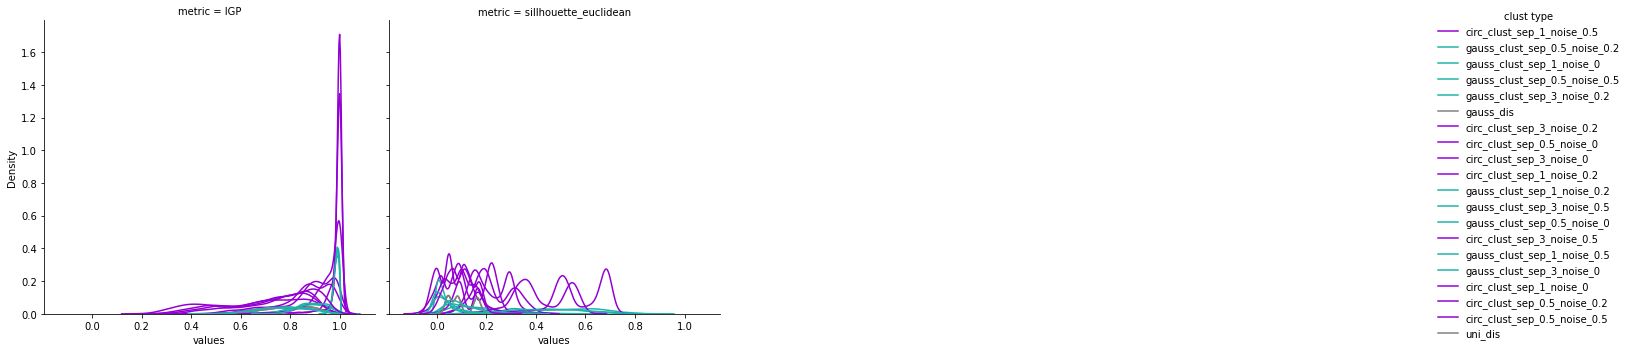

In [193]:
comp_plot = sns.displot(compdf,x = 'values',col = 'metric',hue = 'clust type',kind = 'kde',col_wrap =4,palette=palette)
sep_plot = sns.displot(sepdf,x = 'values',col = 'metric',hue = 'clust type',kind = 'kde',col_wrap =4,palette=palette)
other_plot = sns.displot(otherdf,x = 'values',col = 'metric',hue = 'clust type',kind = 'kde',col_wrap =4,palette=palette)

## Means

In [195]:
comp_means = comp_dict.copy()
sep_means = sep_dict.copy()
other_means = other_dict.copy()

In [196]:
dict_list = [comp_means,sep_means,other_means]
for i in dict_list:
    test_dict = {k + '_' + j:{k2:list_sorter(v2,j) for k2,v2 in v.items() if isinstance(v2[0],list)}for k,v in i.items()for j in ['max','min','mean']}
    i.update(test_dict)
comp_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in comp_means.items() }
sep_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in sep_means.items() }
other_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in other_means.items() }
comp_means = {k:v for k,v in comp_means.items() if len(v) > 0}
sep_means = {k:v for k,v in sep_means.items() if len(v) > 0}
other_means = {k:v for k,v in other_means.items() if len(v) > 0 }

In [200]:
comp_means = {k:{k2:np.mean(v2) for k2,v2 in v.items()} for k,v in comp_means.items()}
sep_means = {k:{k2:np.mean(v2) for k2,v2 in v.items()} for k,v in sep_means.items()}
other_means = {k:{k2:np.mean(v2) for k2,v2 in v.items()} for k,v in other_means.items()}

In [201]:
other_means

{'IGP': {'uni_dis_dim_5_k_2': 0.9272366431634754,
  'uni_dis_dim_5_k_3': 0.8868742774592456,
  'uni_dis_dim_5_k_4': 0.8662350693996298,
  'uni_dis_dim_10_k_2': 0.8473794566350062,
  'uni_dis_dim_10_k_3': 0.7821410438056469,
  'uni_dis_dim_10_k_4': 0.7439558266199249,
  'uni_dis_dim_20_k_2': 0.7762660166223416,
  'uni_dis_dim_20_k_3': 0.6906512603777273,
  'uni_dis_dim_20_k_4': 0.6299021208720184,
  'gauss_dis_dim_5_k_2': 0.9237347653550971,
  'gauss_dis_dim_5_k_3': 0.8864338297749736,
  'gauss_dis_dim_5_k_4': 0.8637534031235417,
  'gauss_dis_dim_10_k_2': 0.8453218888874143,
  'gauss_dis_dim_10_k_3': 0.7763525946052476,
  'gauss_dis_dim_10_k_4': 0.7430702908424235,
  'gauss_dis_dim_20_k_2': 0.7748056835509272,
  'gauss_dis_dim_20_k_3': 0.6859042701363671,
  'gauss_dis_dim_20_k_4': 0.6363251843058275,
  'circ_clust_equal_dim_5_k_2_sep_0.5_noise_0': 0.6678333333333332,
  'circ_clust_equal_dim_5_k_2_sep_0.5_noise_0.2': 0.6639,
  'circ_clust_equal_dim_5_k_2_sep_0.5_noise_0.5': 0.58736666666

## testing

In [ ]:
test_dict = other_means['IGP']
x = 'uni_dis'
new_dict = {k + '_' + x:abs(v -k[x + '_' + ])}

In [203]:
def name_shorten2(x):
    x = re.sub('.*_dim','dim',x)
    x = re.sub('_sep.*','',x)
    return x

In [202]:
x ='circ_clust_equal_dim_5_k_2_sep_0.5_noise_0'
x = re.sub('.*_dim','dim',x)
x = re.sub('_sep.*','',x)
x

'dim_5_k_2'